In [1]:
freq = 15

In [2]:
paciente='paciente2'

In [3]:
import codigo
from codigo import utils
from codigo import model_LSTM
from codigo import model_utils
from cg_ega.cg_ega import CG_EGA

In [4]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [7]:
len(array_Xtest)

1742

In [8]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [9]:
len(array_Ytest)

1742

# Pruebas Vanilla LSTM con dropout

In [10]:
model = keras.models.load_model('modelos/'+paciente+'/vanilla_dropout.h5')

In [11]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Predicción de todo el conjunto de pruebas generales

In [12]:
len(array_Ytest)

1742

55/55 [==============================] - 1s 5ms/step


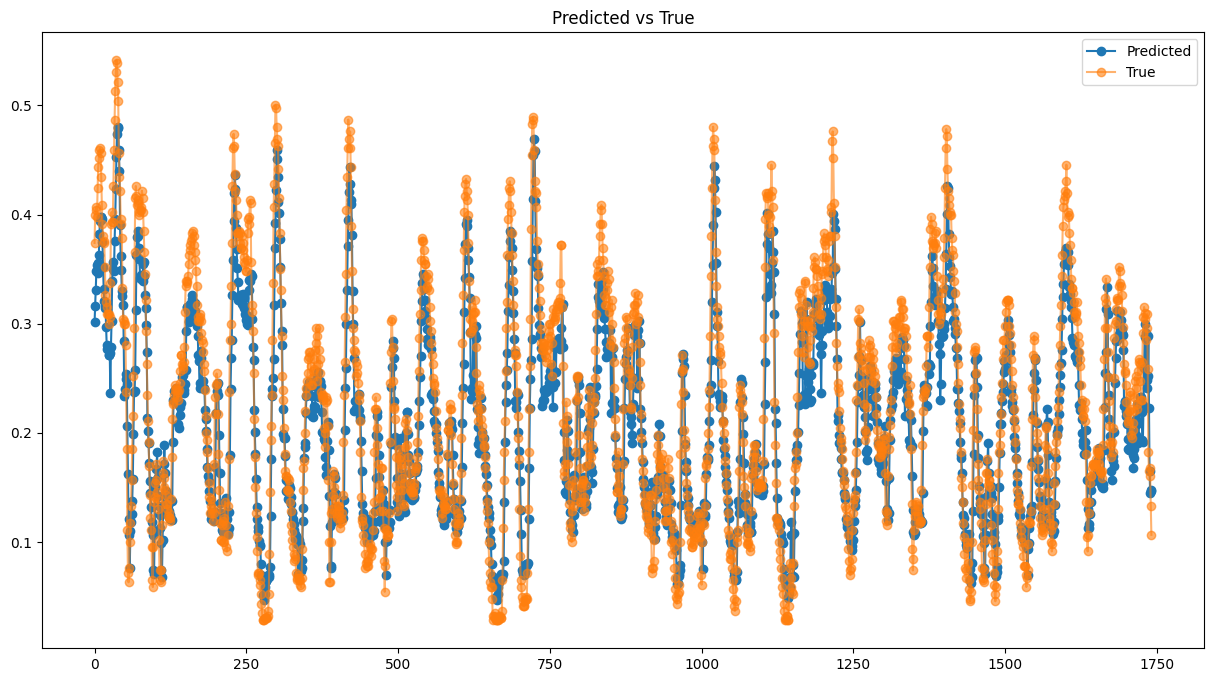

In [13]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [14]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.03153467998152817,
 'mse': 0.04053829141756145,
 'rmse': 0.0016433530710551363}

In [15]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        178.556274
1        185.587067
2        191.993546
3        200.104874
4        202.842270
...             ...
1737     142.343155
1738     115.943924
1739     106.549194
1740     107.798355
1741     107.475067

[1742 rows x 1 columns]

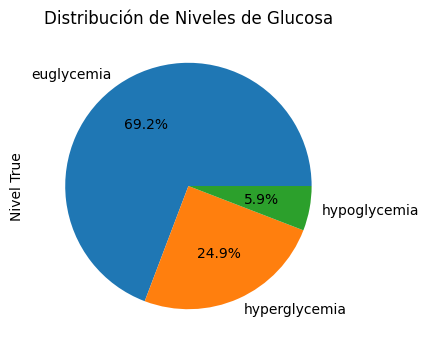

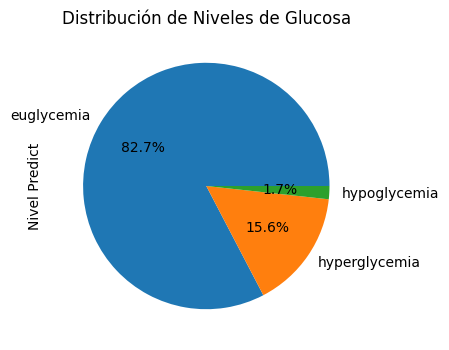

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               212.0  hyperglycemia             178.556274     euglycemia
1               224.0  hyperglycemia             185.587067  hyperglycemia
2               226.0  hyperglycemia             191.993546  hyperglycemia
3               227.0  hyperglycemia             200.104874  hyperglycemia
4               223.0  hyperglycemia             202.842270  hyperglycemia

In [16]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


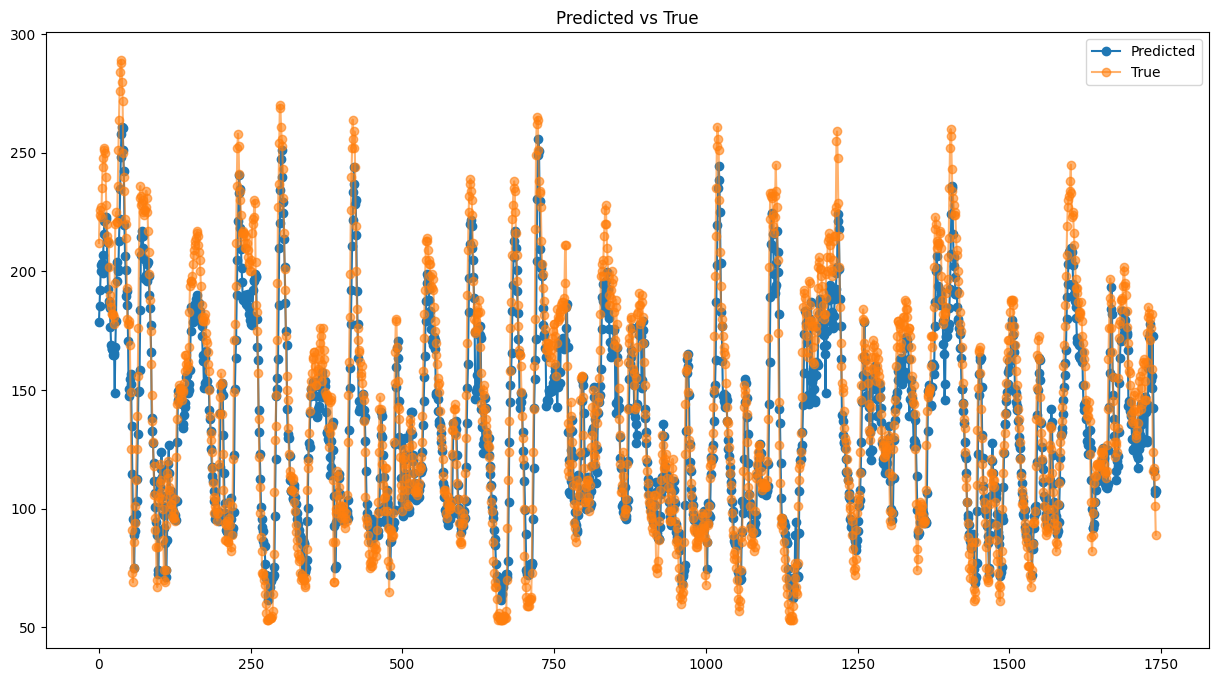

{'mae': 14.505951495632283, 'mse': 18.64761269442421, 'rmse': 347.733459201251}

In [17]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [18]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0             212.0
1             224.0
2             226.0
3             227.0
4             223.0
...             ...
1737          116.0
1738          117.0
1739          114.0
1740          101.0
1741           89.0

[1742 rows x 1 columns]

In [19]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   212.0  178.556274
2023-01-01 00:15:00   224.0  185.587067
2023-01-01 00:30:00   226.0  191.993546
2023-01-01 00:45:00   227.0  200.104874
2023-01-01 01:00:00   223.0  202.842270
...                     ...         ...
2023-01-19 02:15:00   116.0  142.343155
2023-01-19 02:30:00   117.0  115.943924
2023-01-19 02:45:00   114.0  106.549194
2023-01-19 03:00:00   101.0  107.798355
2023-01-19 03:15:00    89.0  107.475067

[1742 rows x 2 columns]

AP, BE, EP: (0.9586444572085009, 0.0068925904652498565, 0.03446295232624928)


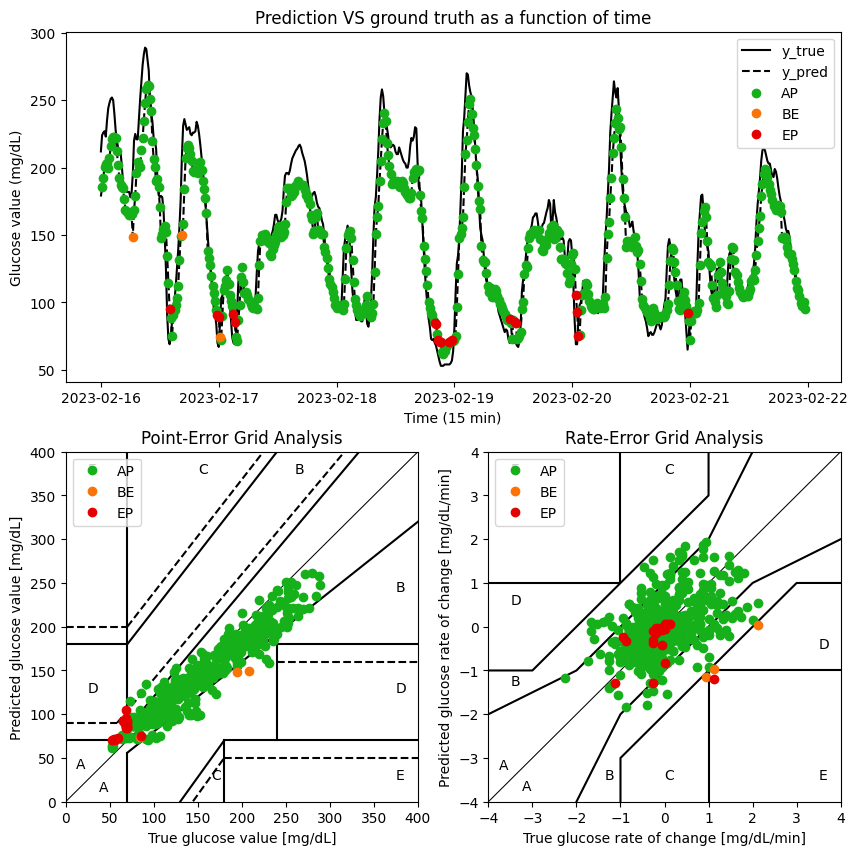

In [20]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [21]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0    2023-02-16 00:00:00   212.0  178.556274       NaN       NaN    NaN   NaN   
1    2023-02-16 00:15:00   224.0  185.587067  0.800000  0.468719     AP     A   
2    2023-02-16 00:30:00   226.0  191.993546  0.133333  0.427099     AP     A   
3    2023-02-16 00:45:00   227.0  200.104874  0.066667  0.540755     AP     A   
4    2023-02-16 01:00:00   223.0  202.842270 -0.266667  0.182493     AP     A   
...                  ...     ...         ...       ...       ...    ...   ...   
1737 2023-03-06 02:15:00   116.0  142.343155 -0.533333 -2.021534     AP     B   
1738 2023-03-06 02:30:00   117.0  115.943924  0.066667 -1.759949     AP     A   
1739 2023-03-06 02:45:00   114.0  106.549194 -0.200000 -0.626315     AP     A   
1740 2023-03-06 03:00:00   101.0  107.798355 -0.866667  0.083277     AP     A   
1741 2023-03-06 03:15:00    89.0  107.475067 -0.800000 -0.021553     AP     B   

     R_EGA  
0      NaN  
1        A  
2        A  
3        A  
4        A  
...    ...  
1737     B  
1738     B  
1739     A  
1740     A  
1741     A  

[1742 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [22]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [23]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 23ms/step


Glucose level Predict  Glucose level True
0               0.301209            0.373913
1               0.316494            0.400000

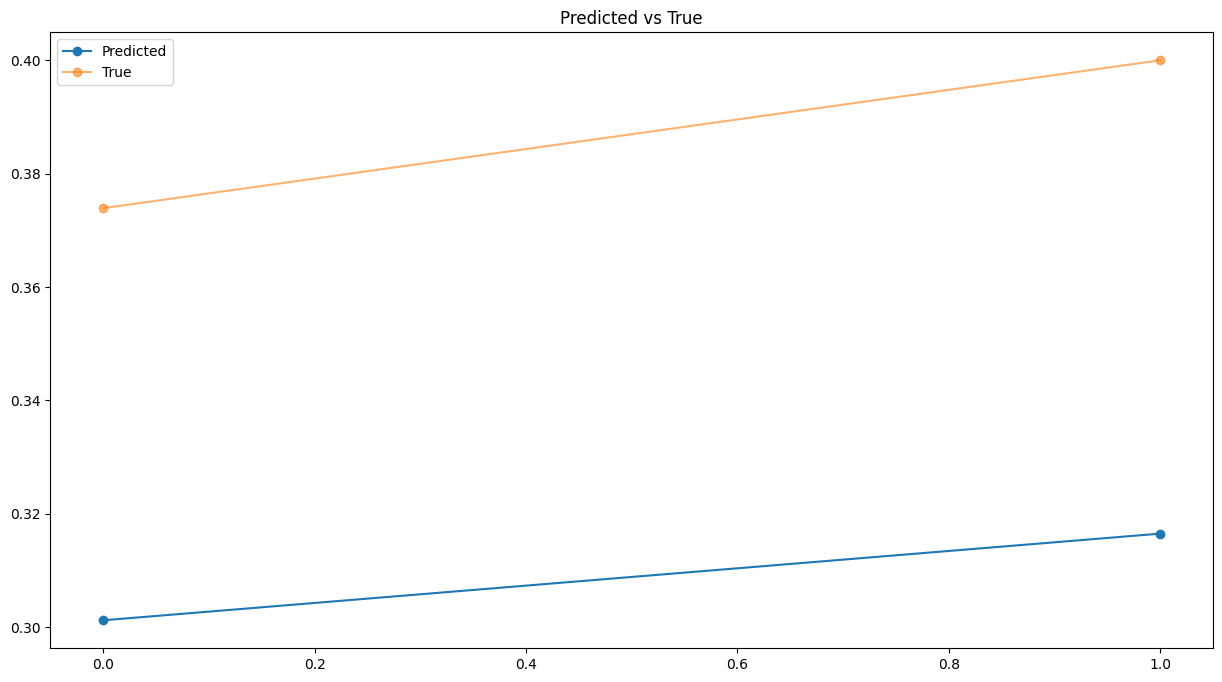

{'mae': 0.07810507105744405,
 'mse': 0.07829160970841242,
 'rmse': 0.0061295761507343775}

In [24]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [25]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             178.556274               212.0
1             185.587067               224.0

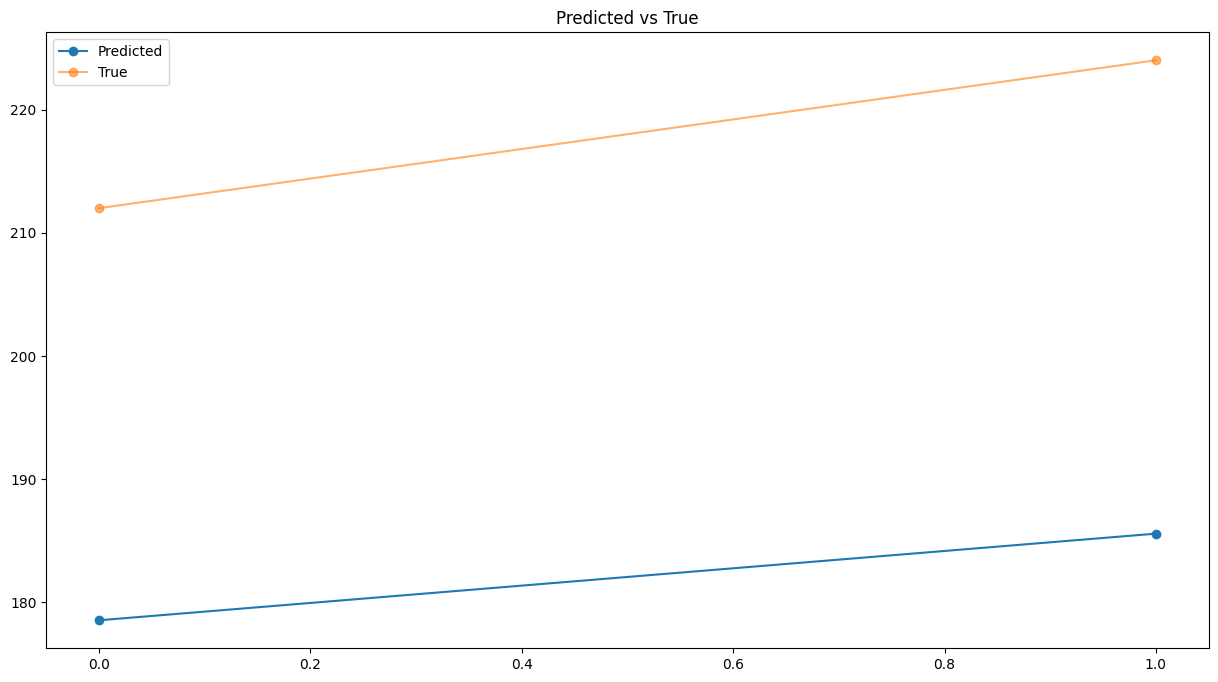

{'mae': 35.92832946777344,
 'mse': 36.014137707218694,
 'rmse': 1297.0181147945113}

In [26]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Vanilla LSTM sin dropout

In [27]:
model = keras.models.load_model('modelos/'+paciente+'/vanilla_NO_dropout.h5')

In [28]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Predicción de todo el conjunto de pruebas generales

In [29]:
len(array_Ytest)

1742

55/55 [==============================] - 0s 5ms/step


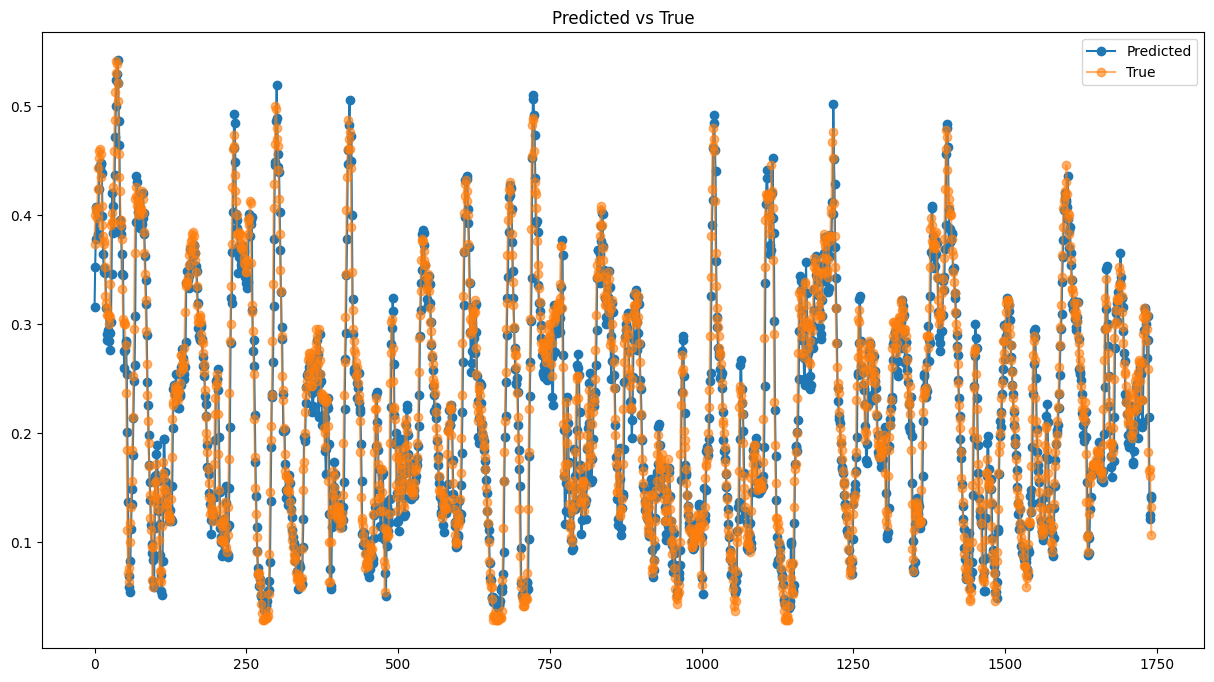

In [30]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [31]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.02106184889299995,
 'mse': 0.0285759111528605,
 'rmse': 0.0008165826982161772}

In [32]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        185.386536
1        201.961655
2        213.807358
3        227.449081
4        225.791962
...             ...
1737     138.741180
1738      97.352875
1739      95.554634
1740     105.267372
1741     104.527885

[1742 rows x 1 columns]

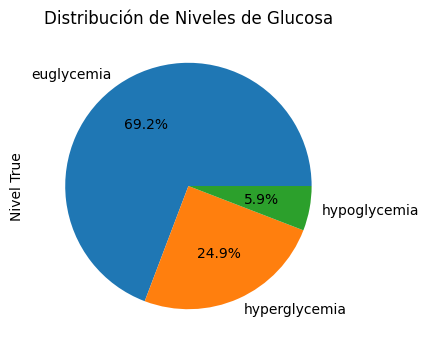

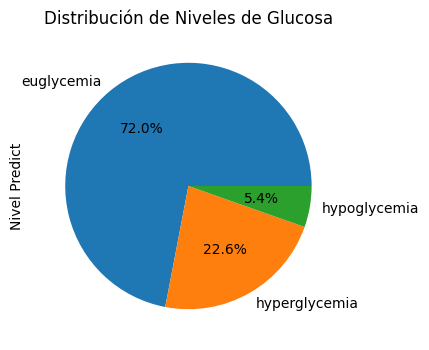

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               212.0  hyperglycemia             185.386536  hyperglycemia
1               224.0  hyperglycemia             201.961655  hyperglycemia
2               226.0  hyperglycemia             213.807358  hyperglycemia
3               227.0  hyperglycemia             227.449081  hyperglycemia
4               223.0  hyperglycemia             225.791962  hyperglycemia

In [33]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


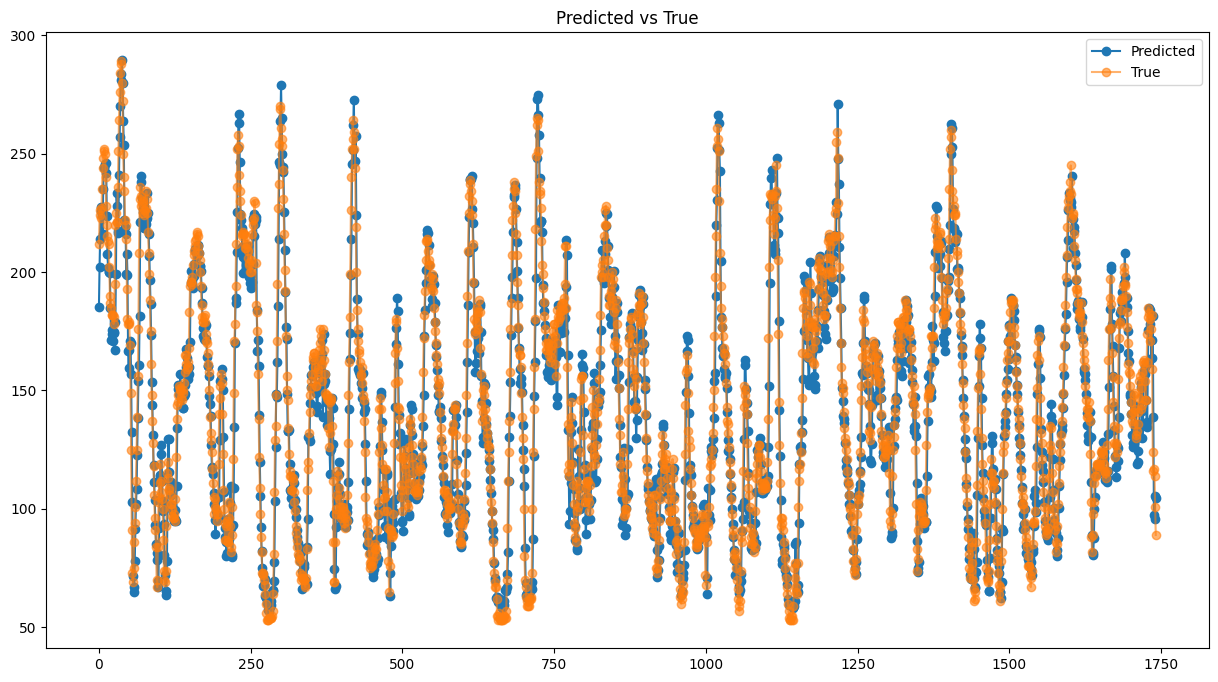

{'mae': 9.688449999768753,
 'mse': 13.144918740127912,
 'rmse': 172.78888868456596}

In [34]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [35]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0             212.0
1             224.0
2             226.0
3             227.0
4             223.0
...             ...
1737          116.0
1738          117.0
1739          114.0
1740          101.0
1741           89.0

[1742 rows x 1 columns]

In [36]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   212.0  185.386536
2023-01-01 00:15:00   224.0  201.961655
2023-01-01 00:30:00   226.0  213.807358
2023-01-01 00:45:00   227.0  227.449081
2023-01-01 01:00:00   223.0  225.791962
...                     ...         ...
2023-01-19 02:15:00   116.0  138.741180
2023-01-19 02:30:00   117.0   97.352875
2023-01-19 02:45:00   114.0   95.554634
2023-01-19 03:00:00   101.0  105.267372
2023-01-19 03:15:00    89.0  104.527885

[1742 rows x 2 columns]

AP, BE, EP: (0.9810453762205629, 0.013785180930499713, 0.005169442848937392)


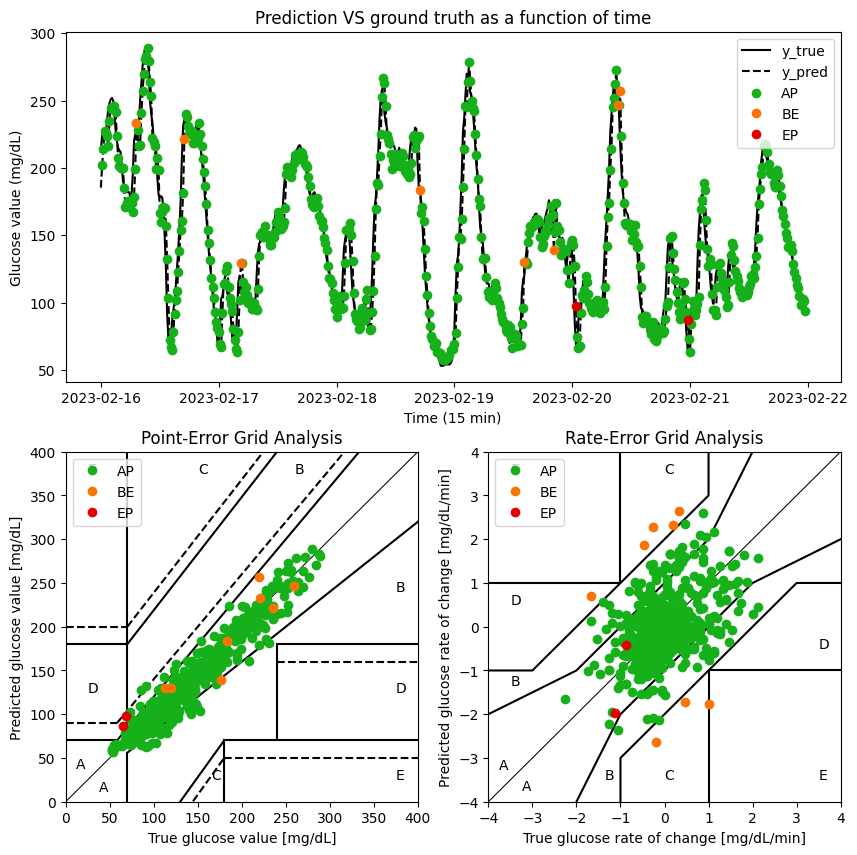

In [37]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [38]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0    2023-02-16 00:00:00   212.0  185.386536       NaN       NaN    NaN   NaN   
1    2023-02-16 00:15:00   224.0  201.961655  0.800000  1.105008     AP     A   
2    2023-02-16 00:30:00   226.0  213.807358  0.133333  0.789714     AP     A   
3    2023-02-16 00:45:00   227.0  227.449081  0.066667  0.909448     AP     A   
4    2023-02-16 01:00:00   223.0  225.791962 -0.266667 -0.110475     AP     A   
...                  ...     ...         ...       ...       ...    ...   ...   
1737 2023-03-06 02:15:00   116.0  138.741180 -0.533333 -2.843246     BE     A   
1738 2023-03-06 02:30:00   117.0   97.352875  0.066667 -2.759220     BE     A   
1739 2023-03-06 02:45:00   114.0   95.554634 -0.200000 -0.119883     AP     A   
1740 2023-03-06 03:00:00   101.0  105.267372 -0.866667  0.647516     AP     A   
1741 2023-03-06 03:15:00    89.0  104.527885 -0.800000 -0.049299     AP     A   

     R_EGA  
0      NaN  
1        A  
2        A  
3        A  
4        A  
...    ...  
1737    lC  
1738    lC  
1739     A  
1740     B  
1741     A  

[1742 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [39]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [40]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 24ms/step


Glucose level Predict  Glucose level True
0               0.316058            0.373913
1               0.352091            0.400000

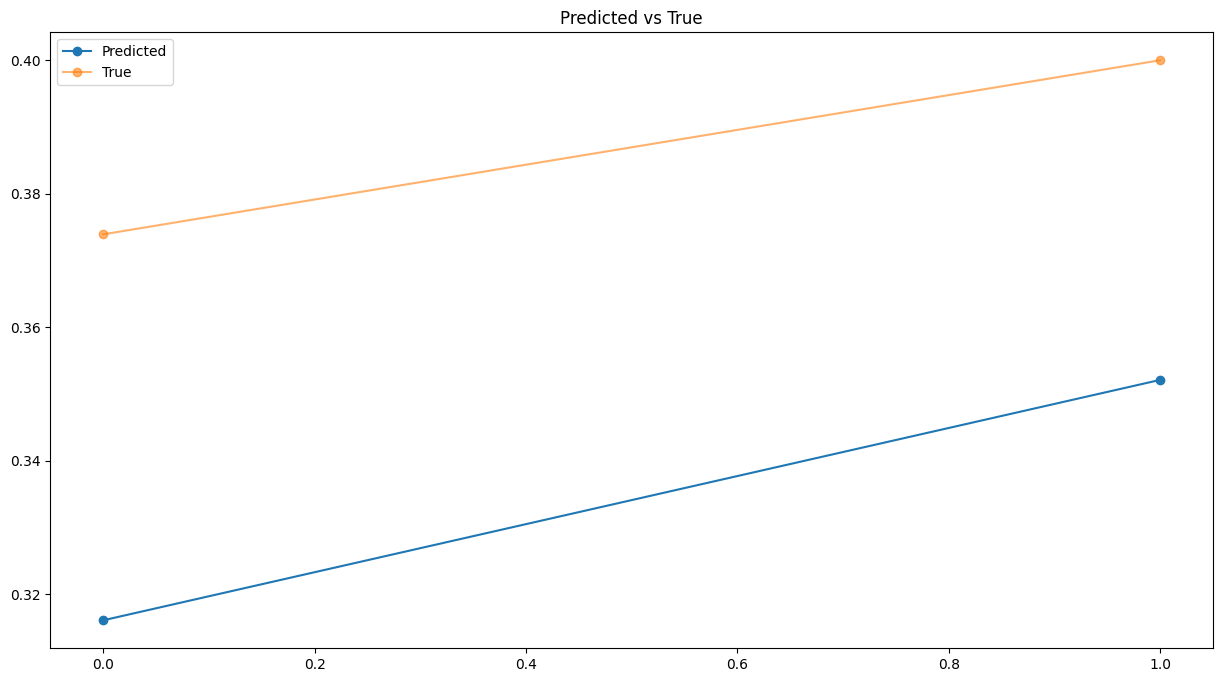

{'mae': 0.0528824119464211,
 'mse': 0.05311572008309491,
 'rmse': 0.002821279719945692}

In [41]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [42]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             185.386536               212.0
1             201.961655               224.0

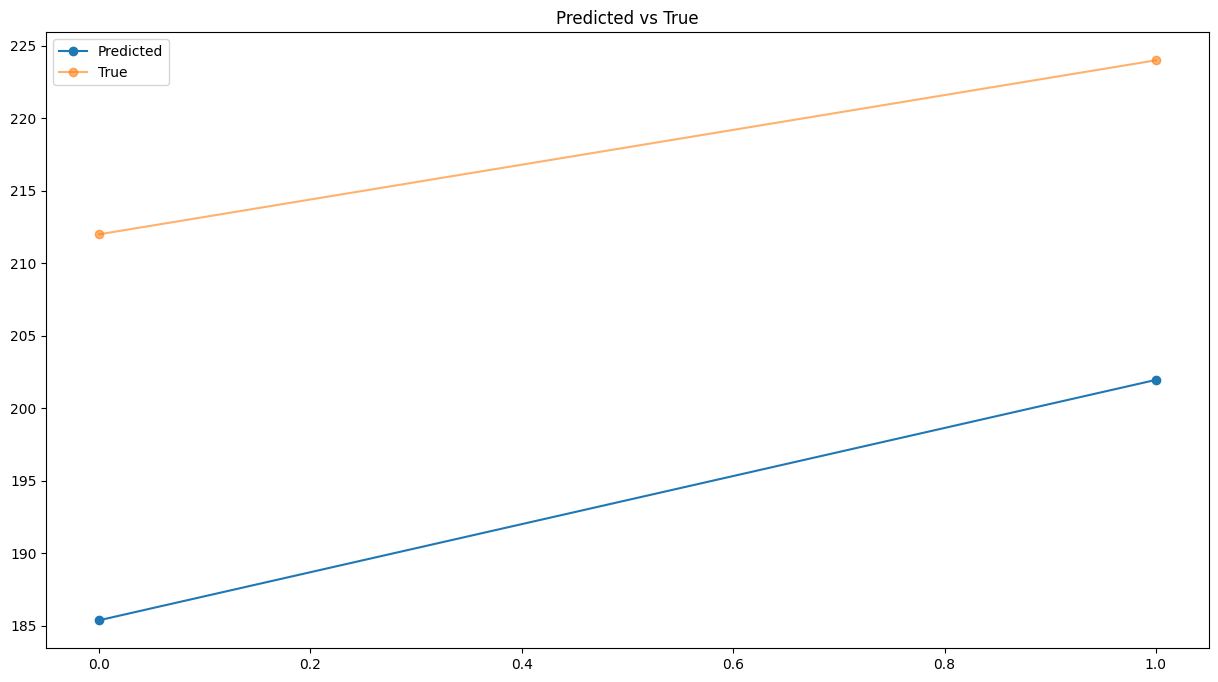

{'mae': 24.325904846191406,
 'mse': 24.433226866184576,
 'rmse': 596.9825750944437}

In [43]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Stacked LSTM con dropout

In [44]:
model = keras.models.load_model('modelos/'+paciente+'/stacked_dropout.h5')

In [45]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Predicción de todo el conjunto de pruebas generales

In [46]:
len(array_Ytest)

1742

55/55 [==============================] - 1s 8ms/step


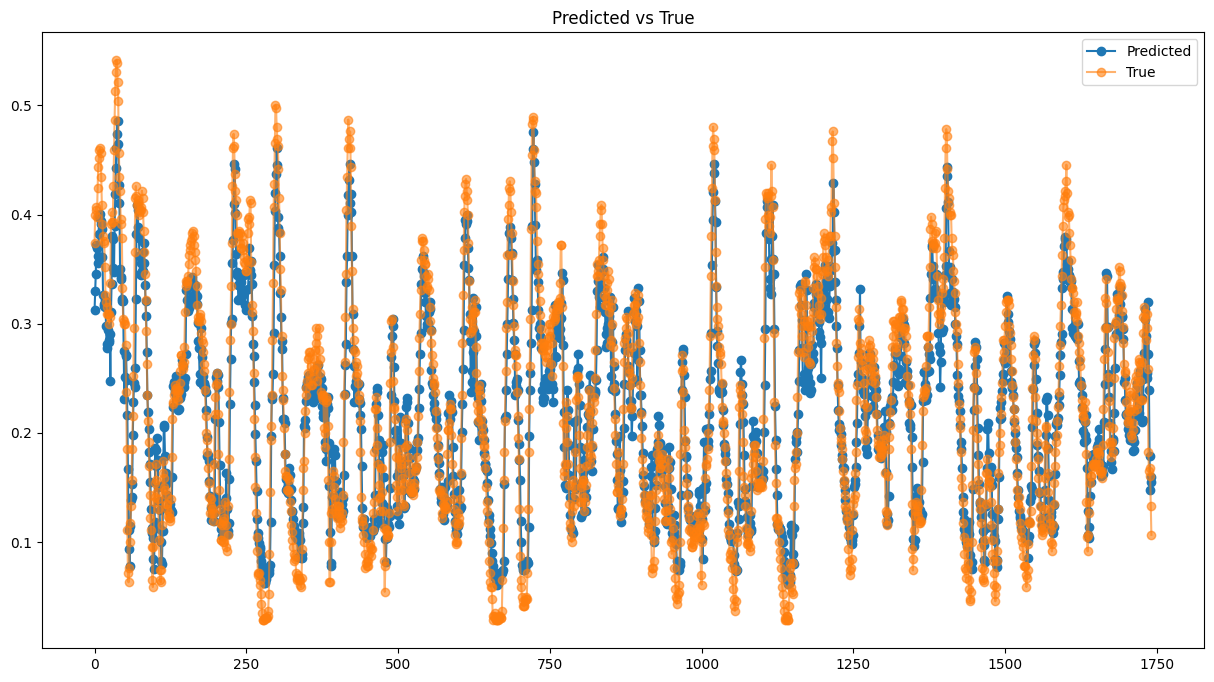

In [47]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [48]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.027992869889180386,
 'mse': 0.03548644884334554,
 'rmse': 0.0012592880515113803}

In [49]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        183.820831
1        191.928223
2        199.111008
3        211.321899
4        209.889023
...             ...
1737     150.050262
1738     122.321861
1739     107.961205
1740     113.513191
1741     111.355934

[1742 rows x 1 columns]

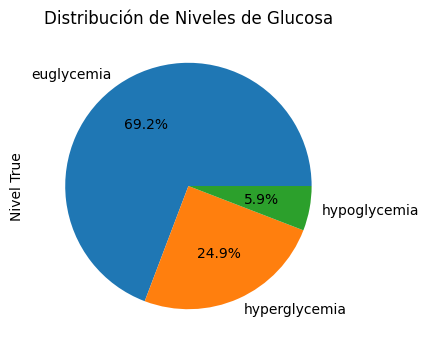

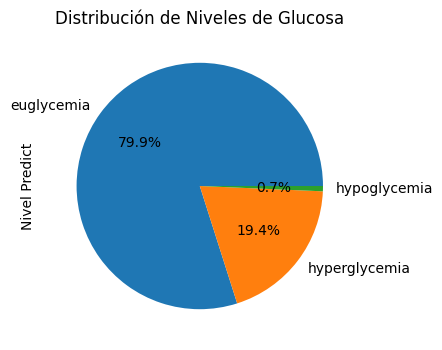

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               212.0  hyperglycemia             183.820831  hyperglycemia
1               224.0  hyperglycemia             191.928223  hyperglycemia
2               226.0  hyperglycemia             199.111008  hyperglycemia
3               227.0  hyperglycemia             211.321899  hyperglycemia
4               223.0  hyperglycemia             209.889023  hyperglycemia

In [50]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


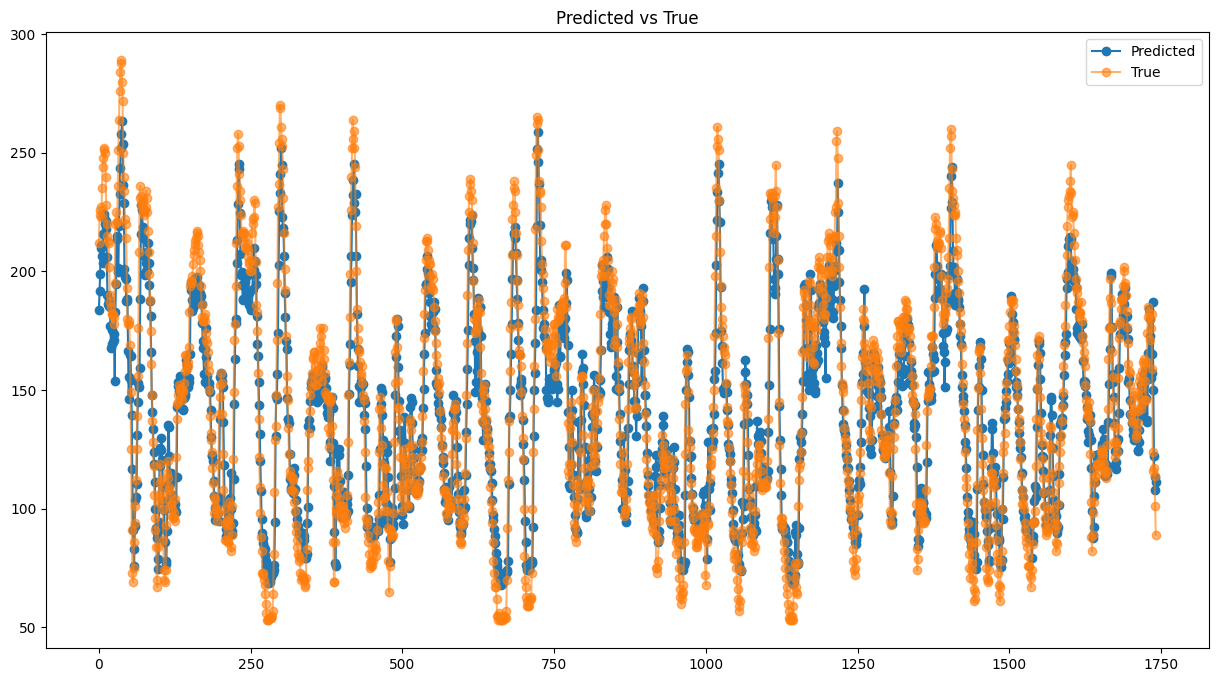

{'mae': 12.876718965655217,
 'mse': 16.323765264374035,
 'rmse': 266.4653124063843}

In [51]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [52]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0             212.0
1             224.0
2             226.0
3             227.0
4             223.0
...             ...
1737          116.0
1738          117.0
1739          114.0
1740          101.0
1741           89.0

[1742 rows x 1 columns]

In [53]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   212.0  183.820831
2023-01-01 00:15:00   224.0  191.928223
2023-01-01 00:30:00   226.0  199.111008
2023-01-01 00:45:00   227.0  211.321899
2023-01-01 01:00:00   223.0  209.889023
...                     ...         ...
2023-01-19 02:15:00   116.0  150.050262
2023-01-19 02:30:00   117.0  122.321861
2023-01-19 02:45:00   114.0  107.961205
2023-01-19 03:00:00   101.0  113.513191
2023-01-19 03:15:00    89.0  111.355934

[1742 rows x 2 columns]

AP, BE, EP: (0.9385410683515221, 0.01263641585295807, 0.048822515795519814)


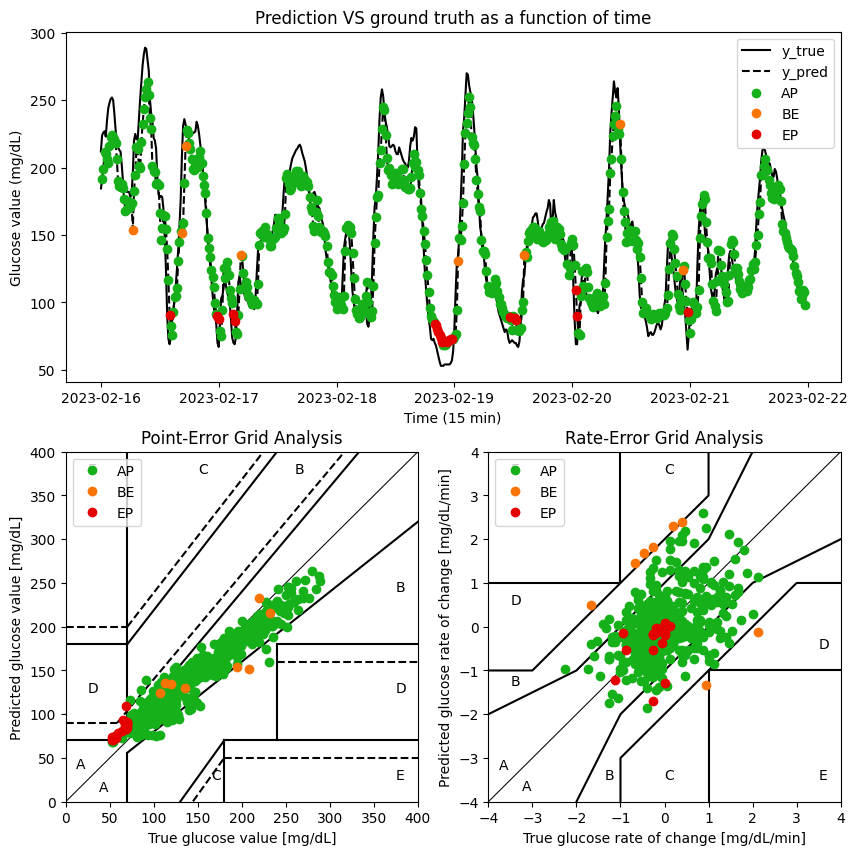

In [54]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [55]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0    2023-02-16 00:00:00   212.0  183.820831       NaN       NaN    NaN   NaN   
1    2023-02-16 00:15:00   224.0  191.928223  0.800000  0.540493     AP     A   
2    2023-02-16 00:30:00   226.0  199.111008  0.133333  0.478852     AP     A   
3    2023-02-16 00:45:00   227.0  211.321899  0.066667  0.814059     AP     A   
4    2023-02-16 01:00:00   223.0  209.889023 -0.266667 -0.095525     AP     A   
...                  ...     ...         ...       ...       ...    ...   ...   
1737 2023-03-06 02:15:00   116.0  150.050262 -0.533333 -2.483392     AP     B   
1738 2023-03-06 02:30:00   117.0  122.321861  0.066667 -1.848560     AP     A   
1739 2023-03-06 02:45:00   114.0  107.961205 -0.200000 -0.957377     AP     A   
1740 2023-03-06 03:00:00   101.0  113.513191 -0.866667  0.370132     AP     A   
1741 2023-03-06 03:15:00    89.0  111.355934 -0.800000 -0.143817     AP     B   

     R_EGA  
0      NaN  
1        A  
2        A  
3        A  
4        A  
...    ...  
1737     B  
1738     B  
1739     A  
1740     B  
1741     A  

[1742 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [56]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [57]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 30ms/step


Glucose level Predict  Glucose level True
0               0.312654            0.373913
1               0.330279            0.400000

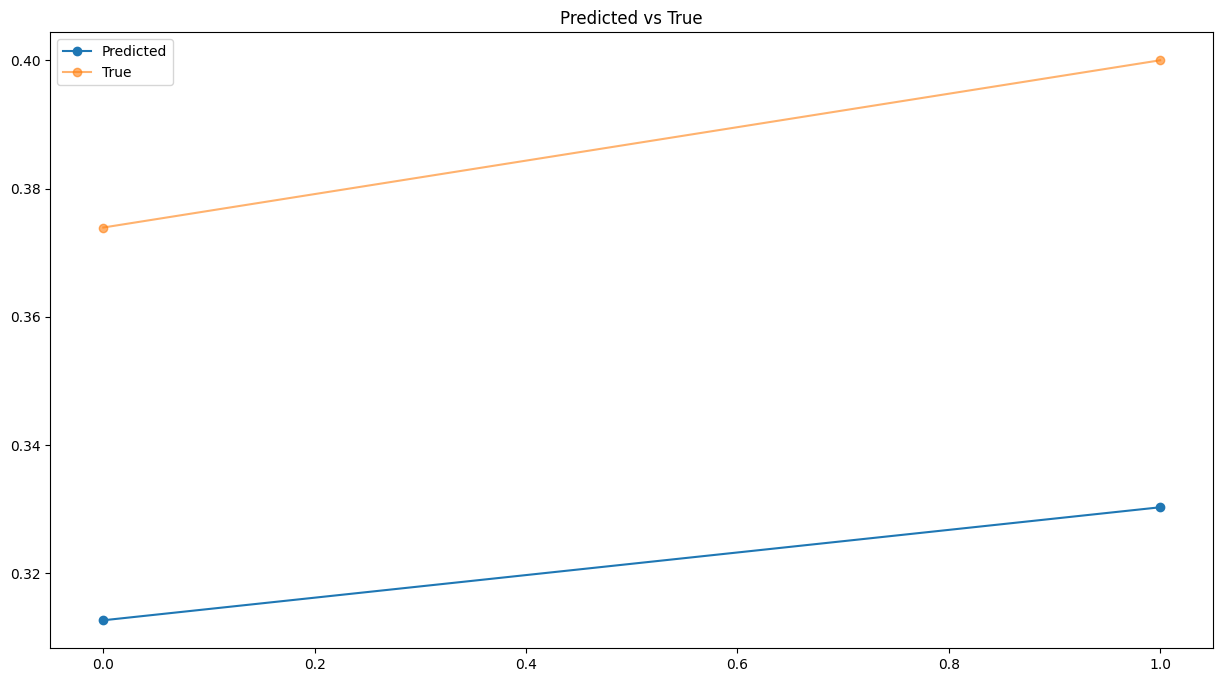

{'mae': 0.06549013542092366,
 'mse': 0.06562667049308181,
 'rmse': 0.004306859880007534}

In [58]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [59]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             183.820831               212.0
1             191.928238               224.0

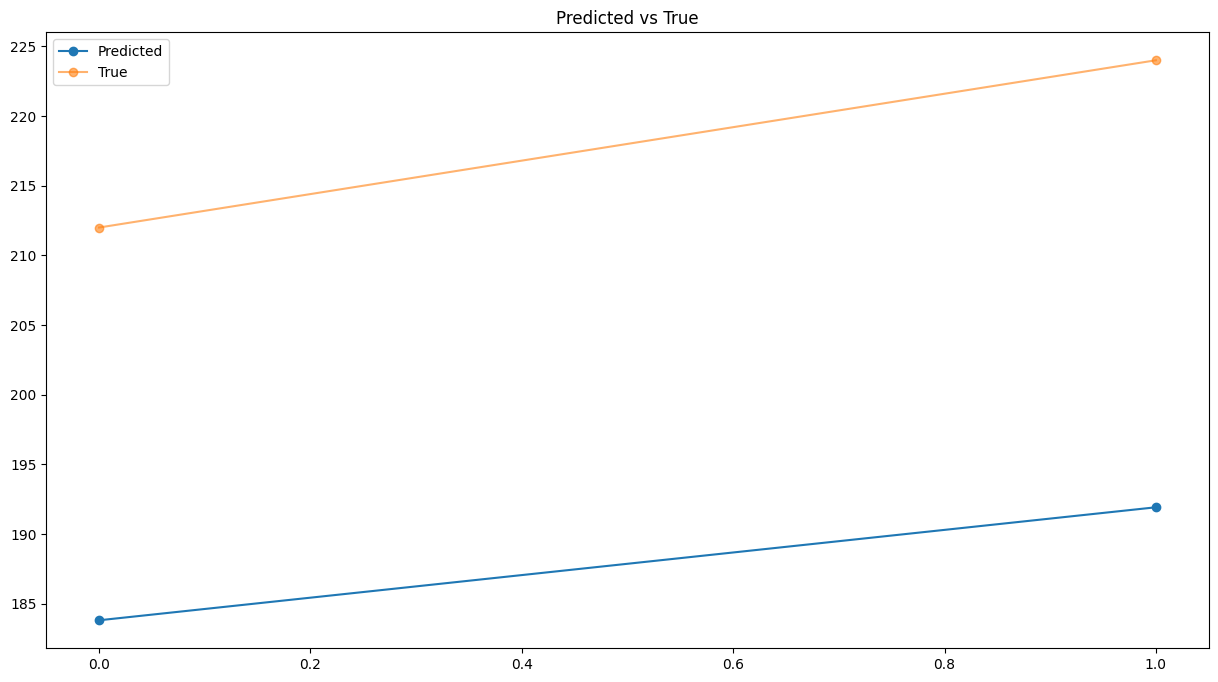

{'mae': 30.125465393066406,
 'mse': 30.188271496753856,
 'rmse': 911.3317359617213}

In [60]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Stacked LSTM sin dropout

In [61]:
model = keras.models.load_model('modelos/'+paciente+'/stacked_NO_dropout.h5')

In [62]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Predicción de todo el conjunto de pruebas generales

In [63]:
len(array_Ytest)

1742

55/55 [==============================] - 1s 9ms/step


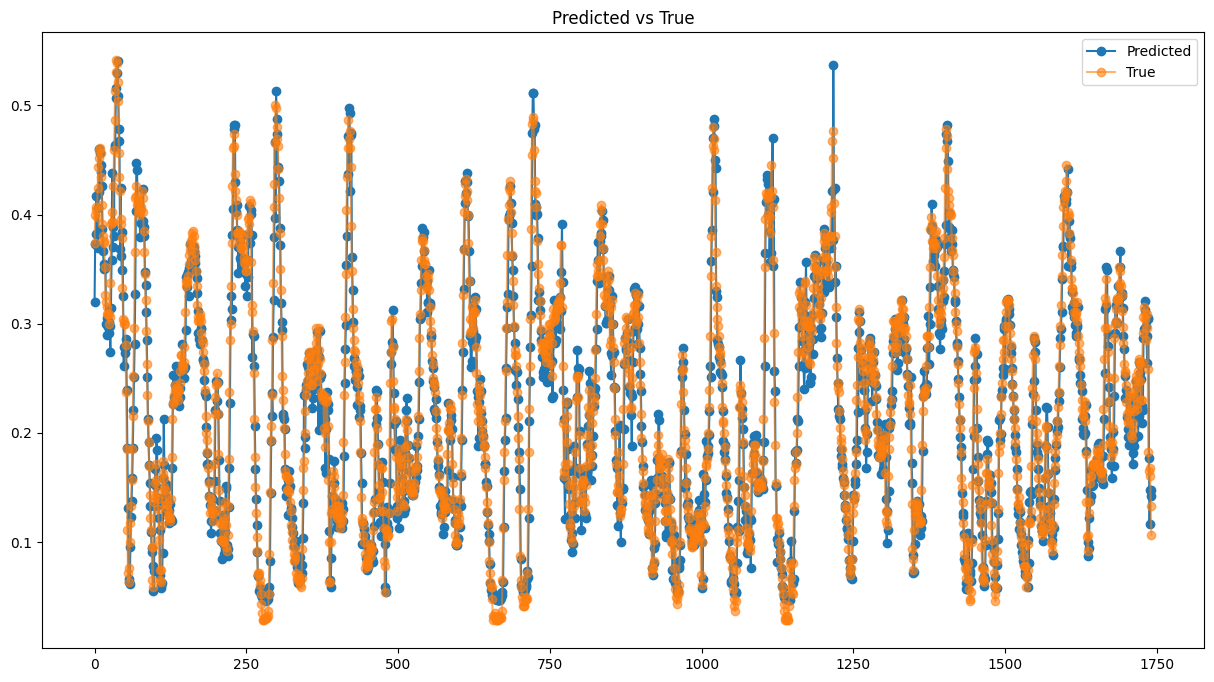

In [64]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [65]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.019258726292633768,
 'mse': 0.026232516040789088,
 'rmse': 0.0006881448978302568}

In [66]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        187.231033
1        211.438568
2        215.806137
3        231.593628
4        215.931351
...             ...
1737     121.218788
1738      93.562271
1739     107.729027
1740     107.890572
1741     105.356178

[1742 rows x 1 columns]

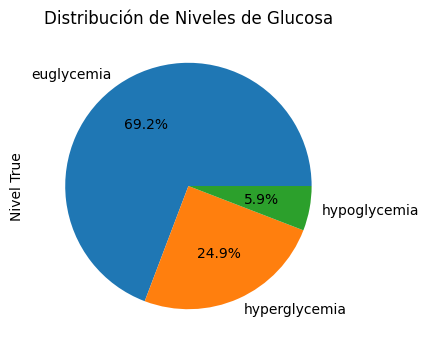

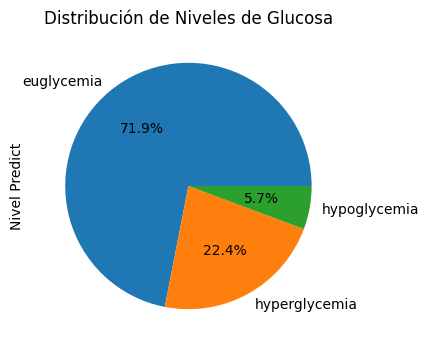

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               212.0  hyperglycemia             187.231033  hyperglycemia
1               224.0  hyperglycemia             211.438568  hyperglycemia
2               226.0  hyperglycemia             215.806137  hyperglycemia
3               227.0  hyperglycemia             231.593628  hyperglycemia
4               223.0  hyperglycemia             215.931351  hyperglycemia

In [67]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


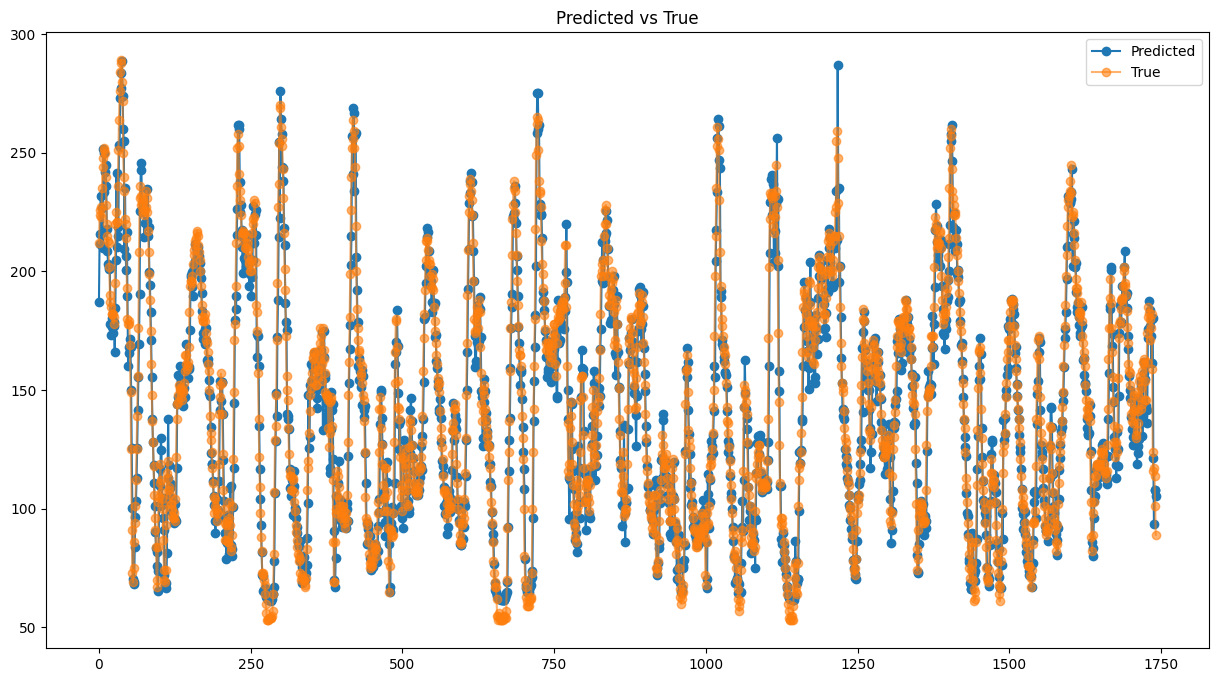

{'mae': 8.85901371181764,
 'mse': 12.066956945345561,
 'rmse': 145.61144992082347}

In [68]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [69]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0             212.0
1             224.0
2             226.0
3             227.0
4             223.0
...             ...
1737          116.0
1738          117.0
1739          114.0
1740          101.0
1741           89.0

[1742 rows x 1 columns]

In [70]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   212.0  187.231033
2023-01-01 00:15:00   224.0  211.438568
2023-01-01 00:30:00   226.0  215.806137
2023-01-01 00:45:00   227.0  231.593628
2023-01-01 01:00:00   223.0  215.931351
...                     ...         ...
2023-01-19 02:15:00   116.0  121.218788
2023-01-19 02:30:00   117.0   93.562271
2023-01-19 02:45:00   114.0  107.729027
2023-01-19 03:00:00   101.0  107.890572
2023-01-19 03:15:00    89.0  105.356178

[1742 rows x 2 columns]

AP, BE, EP: (0.9712808730614589, 0.02125215393452039, 0.007466973004020678)


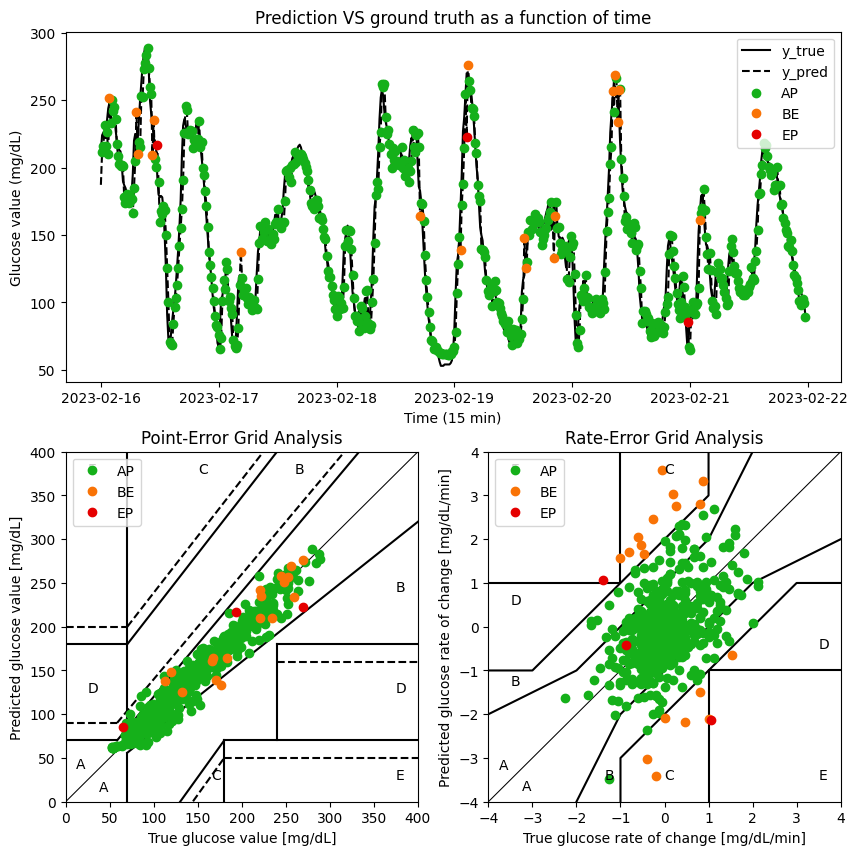

In [71]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [72]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0    2023-02-16 00:00:00   212.0  187.231033       NaN       NaN    NaN   NaN   
1    2023-02-16 00:15:00   224.0  211.438568  0.800000  1.613836     AP     A   
2    2023-02-16 00:30:00   226.0  215.806137  0.133333  0.291171     AP     A   
3    2023-02-16 00:45:00   227.0  231.593628  0.066667  1.052499     AP     A   
4    2023-02-16 01:00:00   223.0  215.931351 -0.266667 -1.044152     AP     A   
...                  ...     ...         ...       ...       ...    ...   ...   
1737 2023-03-06 02:15:00   116.0  121.218788 -0.533333 -3.940708     BE     A   
1738 2023-03-06 02:30:00   117.0   93.562271  0.066667 -1.843768     AP     B   
1739 2023-03-06 02:45:00   114.0  107.729027 -0.200000  0.944450     AP     A   
1740 2023-03-06 03:00:00   101.0  107.890572 -0.866667  0.010770     AP     A   
1741 2023-03-06 03:15:00    89.0  105.356178 -0.800000 -0.168960     AP     A   

     R_EGA  
0      NaN  
1        A  
2        A  
3        A  
4        A  
...    ...  
1737    lC  
1738     B  
1739     B  
1740     A  
1741     A  

[1742 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [73]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [74]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 29ms/step


Glucose level Predict  Glucose level True
0               0.320068            0.373913
1               0.372693            0.400000

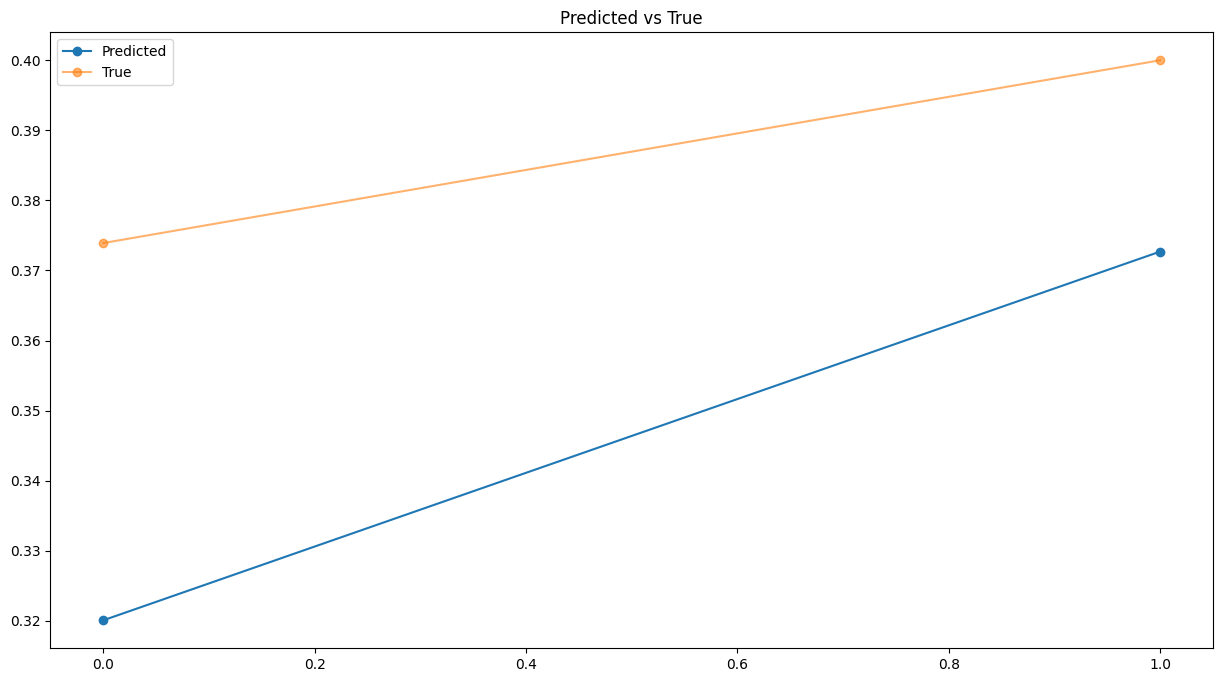

{'mae': 0.040576496590738725,
 'mse': 0.042690971174463924,
 'rmse': 0.0018225190198189098}

In [75]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [76]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             187.231064               212.0
1             211.438568               224.0

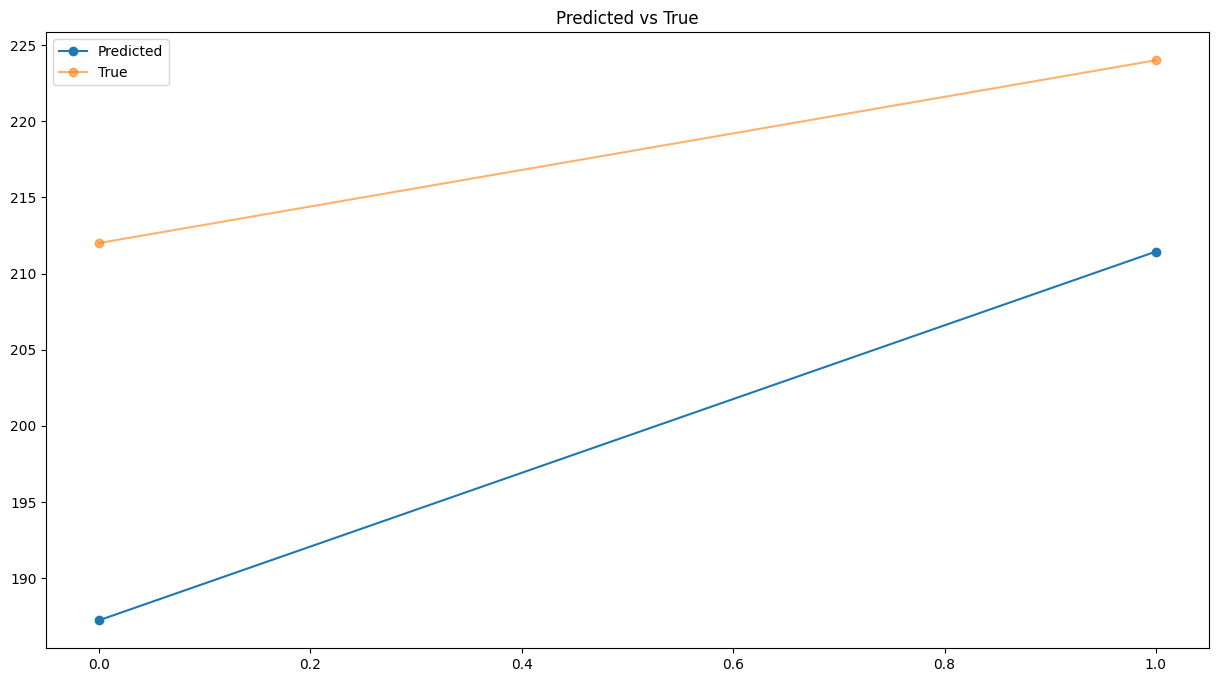

{'mae': 18.665184020996094,
 'mse': 19.637843177859068,
 'rmse': 385.6448846781859}

In [77]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Bidirectional LSTM con dropout

In [78]:
model = keras.models.load_model('modelos/'+paciente+'/bidirectional_dropout.h5')

In [79]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Predicción de todo el conjunto de pruebas generales

In [80]:
len(array_Ytest)

1742

55/55 [==============================] - 1s 6ms/step


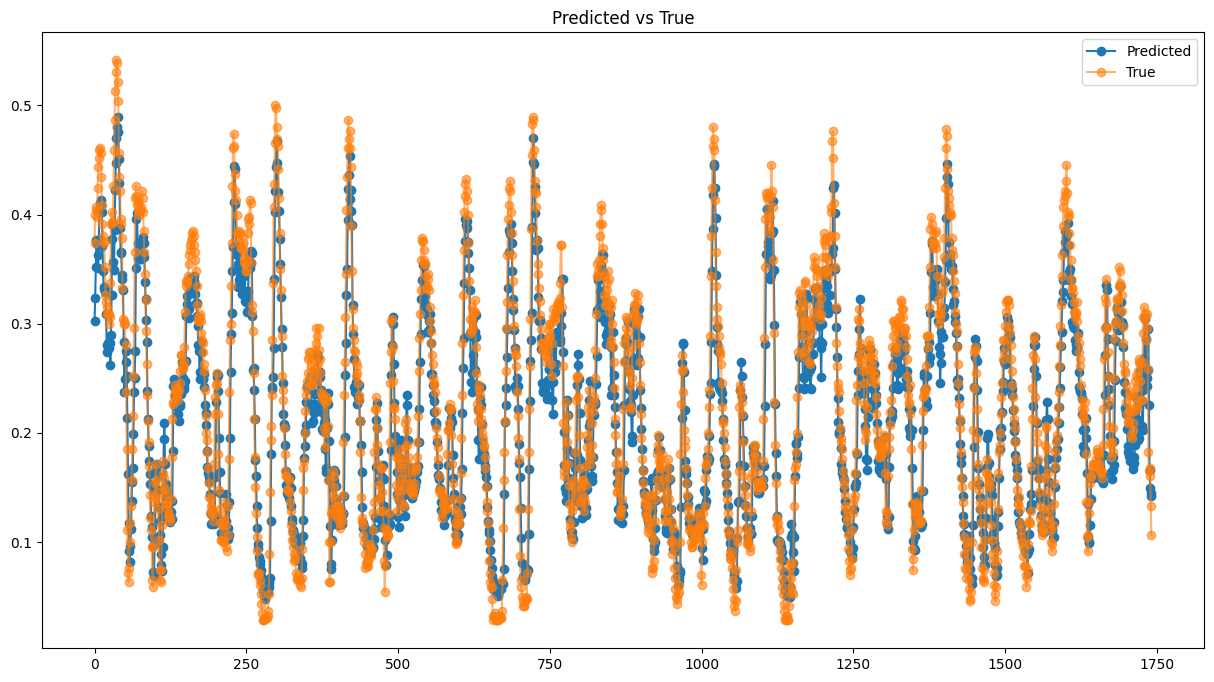

In [81]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [82]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.027847257161927316,
 'mse': 0.036028461792967,
 'rmse': 0.0012980500591672829}

In [83]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        179.197327
1        188.738403
2        201.991150
3        213.340347
4        211.706467
...             ...
1737     143.820480
1738     116.457901
1739     108.842117
1740     106.496231
1741     105.212822

[1742 rows x 1 columns]

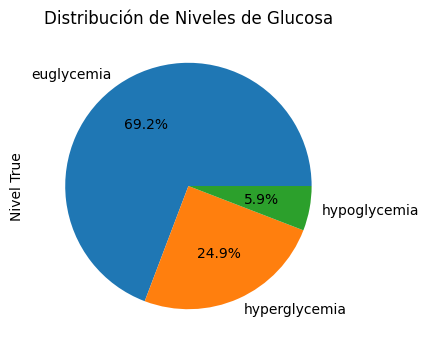

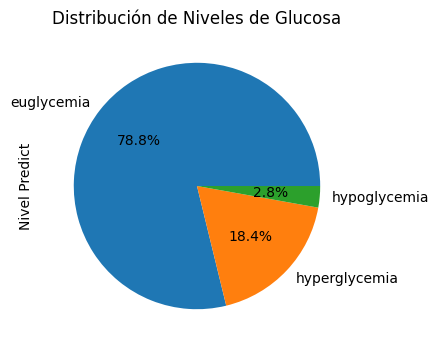

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               212.0  hyperglycemia             179.197327     euglycemia
1               224.0  hyperglycemia             188.738403  hyperglycemia
2               226.0  hyperglycemia             201.991150  hyperglycemia
3               227.0  hyperglycemia             213.340347  hyperglycemia
4               223.0  hyperglycemia             211.706467  hyperglycemia

In [84]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


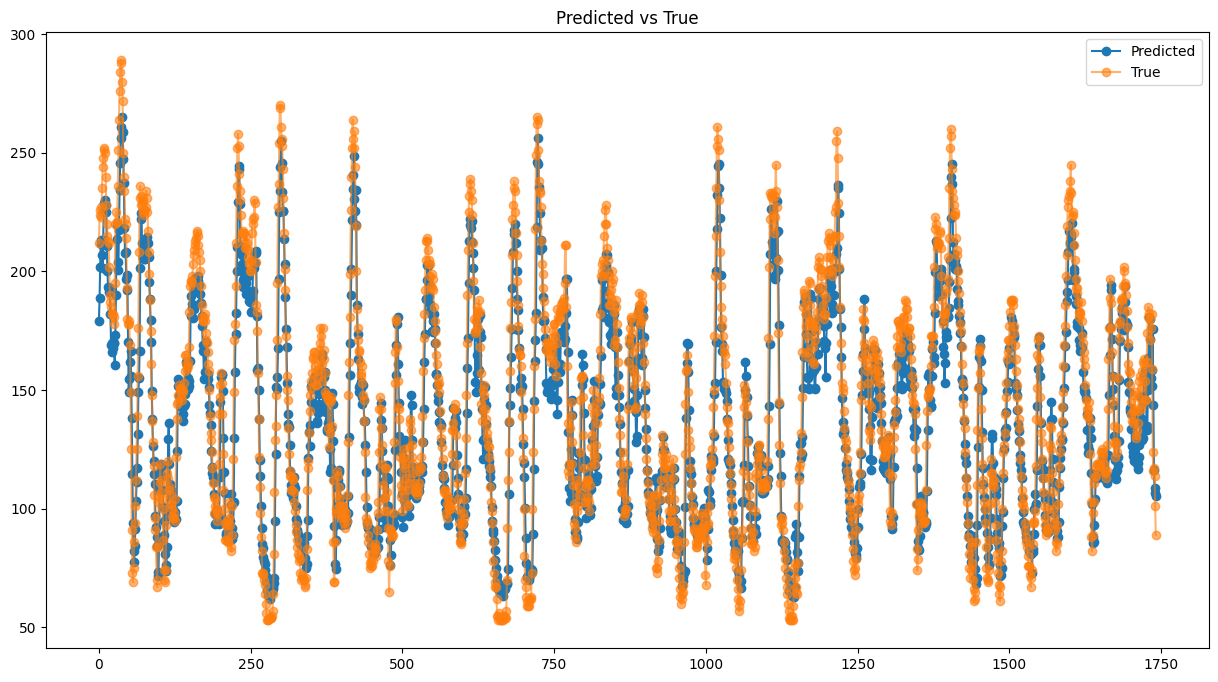

{'mae': 12.809737434051431,
 'mse': 16.57309146483442,
 'rmse': 274.66736070176745}

In [85]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [86]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0             212.0
1             224.0
2             226.0
3             227.0
4             223.0
...             ...
1737          116.0
1738          117.0
1739          114.0
1740          101.0
1741           89.0

[1742 rows x 1 columns]

In [87]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   212.0  179.197327
2023-01-01 00:15:00   224.0  188.738403
2023-01-01 00:30:00   226.0  201.991150
2023-01-01 00:45:00   227.0  213.340347
2023-01-01 01:00:00   223.0  211.706467
...                     ...         ...
2023-01-19 02:15:00   116.0  143.820480
2023-01-19 02:30:00   117.0  116.457901
2023-01-19 02:45:00   114.0  108.842117
2023-01-19 03:00:00   101.0  106.496231
2023-01-19 03:15:00    89.0  105.212822

[1742 rows x 2 columns]

AP, BE, EP: (0.9695577254451465, 0.007466973004020678, 0.022975301550832855)


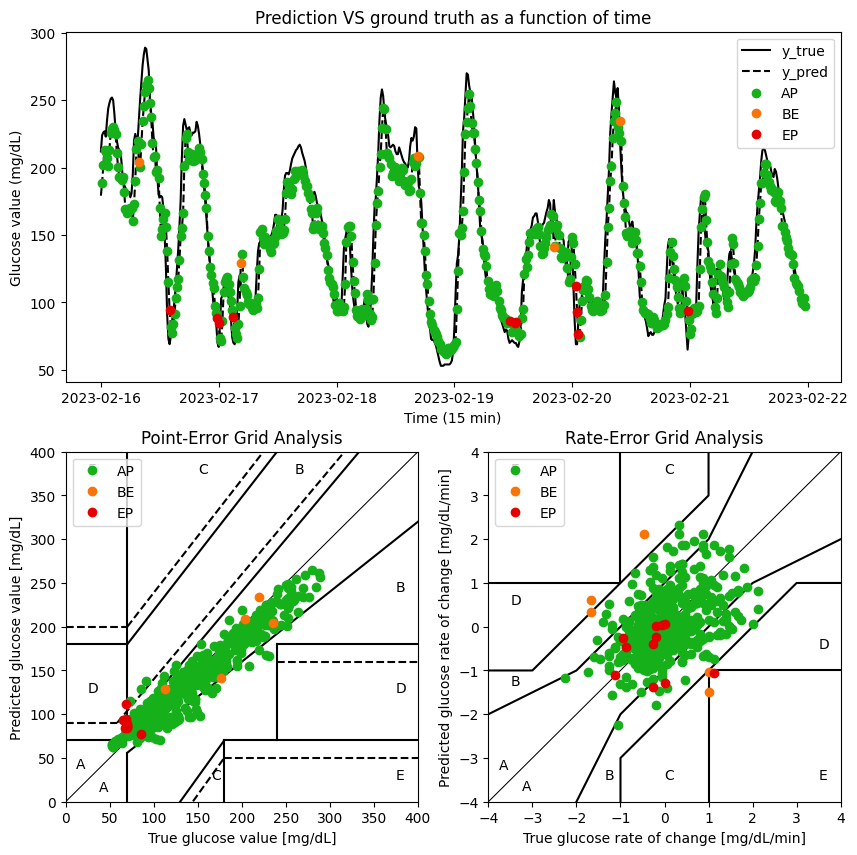

In [88]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [89]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0    2023-02-16 00:00:00   212.0  179.197327       NaN       NaN    NaN   NaN   
1    2023-02-16 00:15:00   224.0  188.738403  0.800000  0.636072     AP     A   
2    2023-02-16 00:30:00   226.0  201.991150  0.133333  0.883516     AP     A   
3    2023-02-16 00:45:00   227.0  213.340347  0.066667  0.756613     AP     A   
4    2023-02-16 01:00:00   223.0  211.706467 -0.266667 -0.108925     AP     A   
...                  ...     ...         ...       ...       ...    ...   ...   
1737 2023-03-06 02:15:00   116.0  143.820480 -0.533333 -2.136721     AP     B   
1738 2023-03-06 02:30:00   117.0  116.457901  0.066667 -1.824172     AP     A   
1739 2023-03-06 02:45:00   114.0  108.842117 -0.200000 -0.507719     AP     A   
1740 2023-03-06 03:00:00   101.0  106.496231 -0.866667 -0.156392     AP     A   
1741 2023-03-06 03:15:00    89.0  105.212822 -0.800000 -0.085561     AP     A   

     R_EGA  
0      NaN  
1        A  
2        A  
3        A  
4        A  
...    ...  
1737     B  
1738     B  
1739     A  
1740     A  
1741     A  

[1742 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [90]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [91]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 27ms/step


Glucose level Predict  Glucose level True
0               0.302603            0.373913
1               0.323344            0.400000

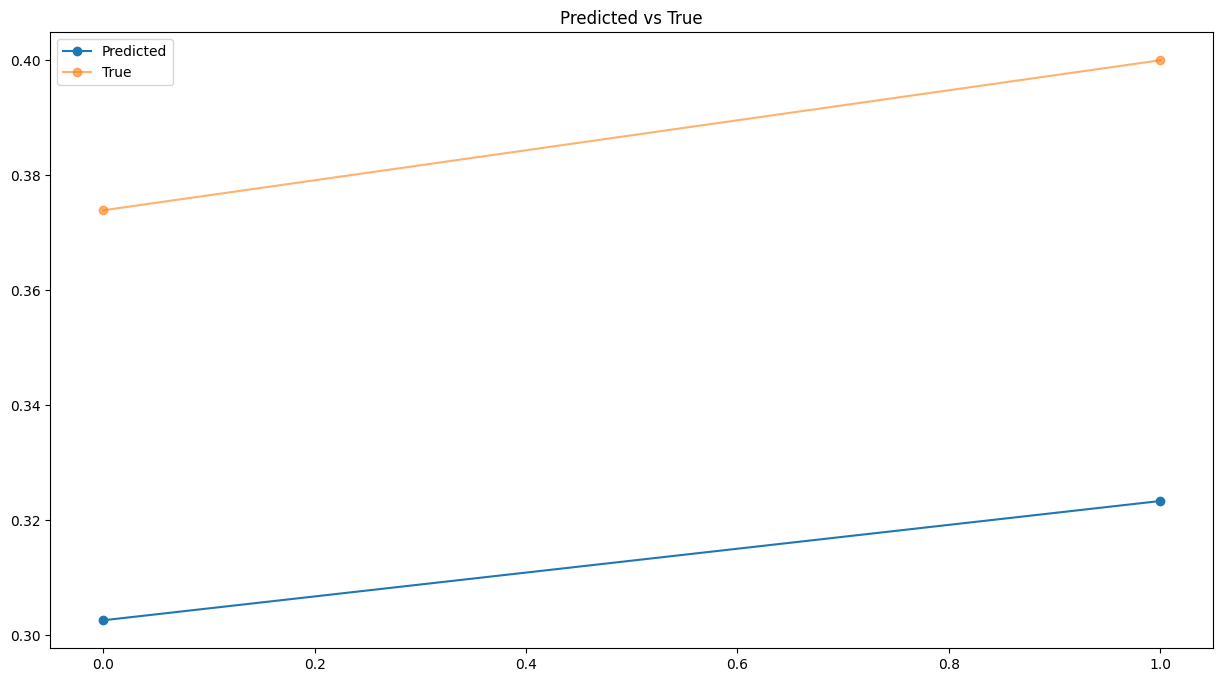

{'mae': 0.0739829032317452,
 'mse': 0.07403116604935545,
 'rmse': 0.005480613546627239}

In [92]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [93]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             179.197327               212.0
1             188.738403               224.0

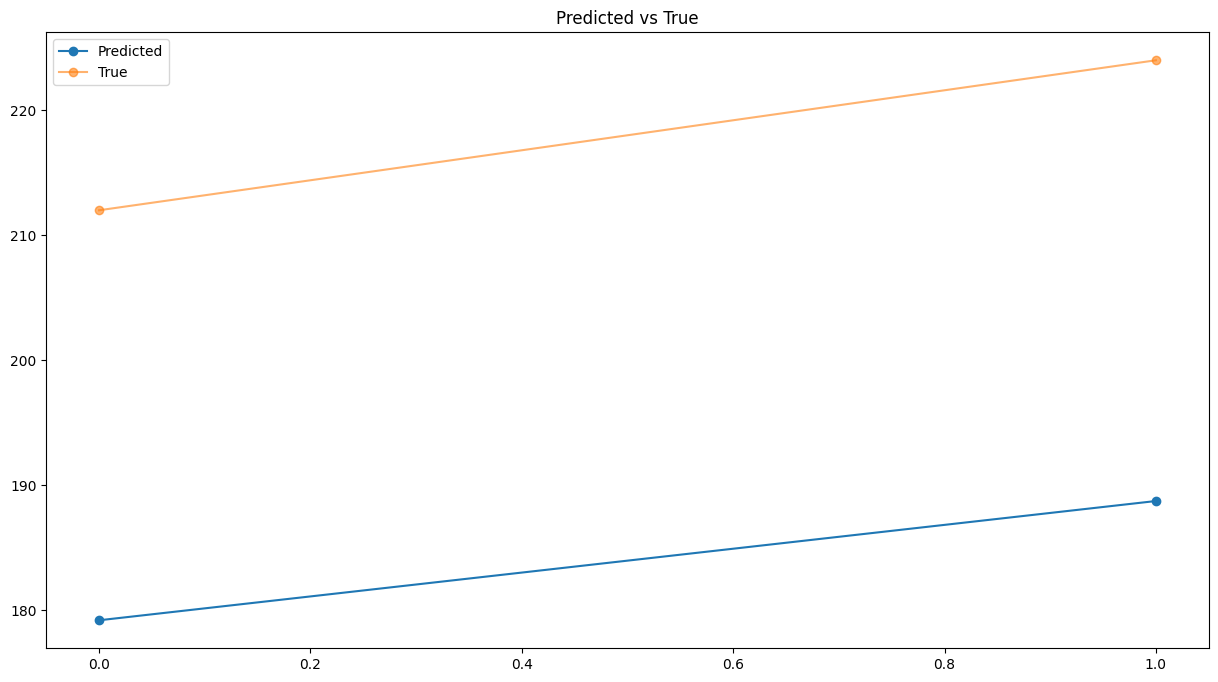

{'mae': 34.032135009765625,
 'mse': 34.05433583731625,
 'rmse': 1159.6977893207222}

In [94]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)

# Pruebas Bidirectional LSTM sin dropout

In [95]:
model = keras.models.load_model('modelos/'+paciente+'/bidirectional_NO_dropout.h5')

In [96]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Predicción de todo el conjunto de pruebas generales

In [97]:
len(array_Ytest)

1742

55/55 [==============================] - 1s 6ms/step


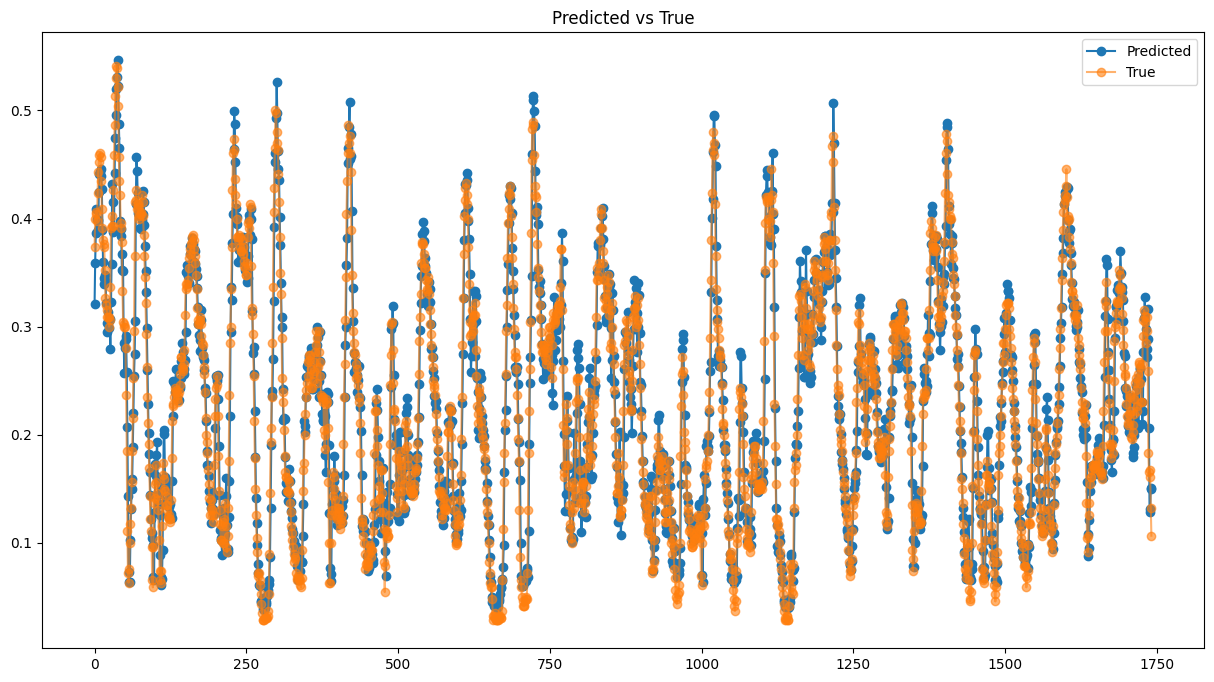

In [98]:
yhat = model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [99]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.02071022617752509,
 'mse': 0.027527065048230877,
 'rmse': 0.000757739310169534}

In [100]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
yhat_df = pd.DataFrame(yhat_scaled, columns=['Glucose level'])
yhat_df

Glucose level
0        187.546936
1        205.078506
2        217.799957
3        227.980637
4        223.734833
...             ...
1737     134.719528
1738      99.232292
1739     100.388031
1740     109.266541
1741     108.804344

[1742 rows x 1 columns]

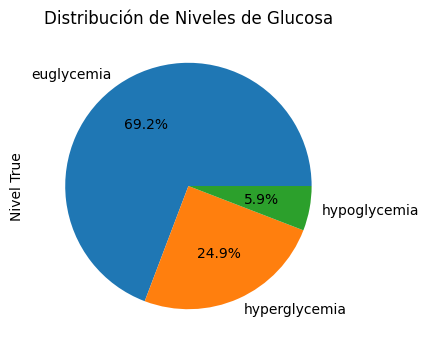

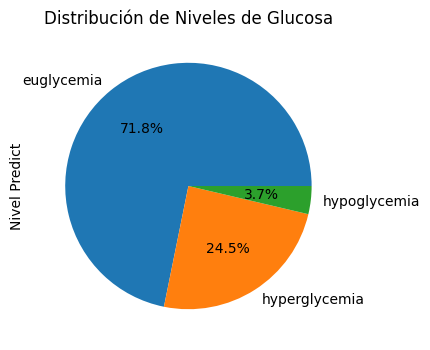

Glucose level True     Nivel True  Glucose level Predict  Nivel Predict
0               212.0  hyperglycemia             187.546936  hyperglycemia
1               224.0  hyperglycemia             205.078506  hyperglycemia
2               226.0  hyperglycemia             217.799957  hyperglycemia
3               227.0  hyperglycemia             227.980637  hyperglycemia
4               223.0  hyperglycemia             223.734833  hyperglycemia

In [101]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


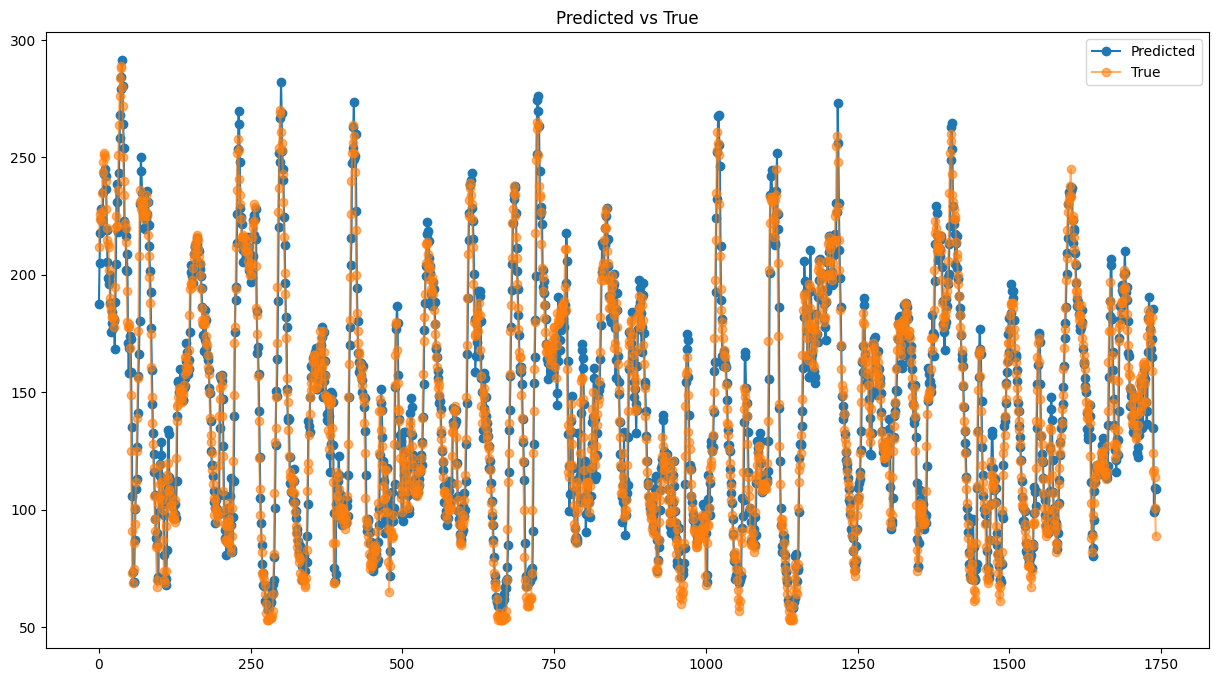

{'mae': 9.526703809350558,
 'mse': 12.662449855555419,
 'rmse': 160.33763634445546}

In [102]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [103]:
array_Ytest_scaled=scalerGlucosa.inverse_transform(array_Ytest)
array_Ytest_df = pd.DataFrame(array_Ytest_scaled, columns=['Glucose level'])
array_Ytest_df

Glucose level
0             212.0
1             224.0
2             226.0
3             227.0
4             223.0
...             ...
1737          116.0
1738          117.0
1739          114.0
1740          101.0
1741           89.0

[1742 rows x 1 columns]

In [104]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=array_Ytest_df['Glucose level']
dfPlot['y_pred']=yhat_df['Glucose level']
dfPlot.index=pd.date_range("2023-01-01", periods=len(array_Ytest), freq="15min")
dfPlot

y_true      y_pred
2023-01-01 00:00:00   212.0  187.546936
2023-01-01 00:15:00   224.0  205.078506
2023-01-01 00:30:00   226.0  217.799957
2023-01-01 00:45:00   227.0  227.980637
2023-01-01 01:00:00   223.0  223.734833
...                     ...         ...
2023-01-19 02:15:00   116.0  134.719528
2023-01-19 02:30:00   117.0   99.232292
2023-01-19 02:45:00   114.0  100.388031
2023-01-19 03:00:00   101.0  109.266541
2023-01-19 03:15:00    89.0  108.804344

[1742 rows x 2 columns]

AP, BE, EP: (0.9781734635267088, 0.013785180930499713, 0.0080413555427915)


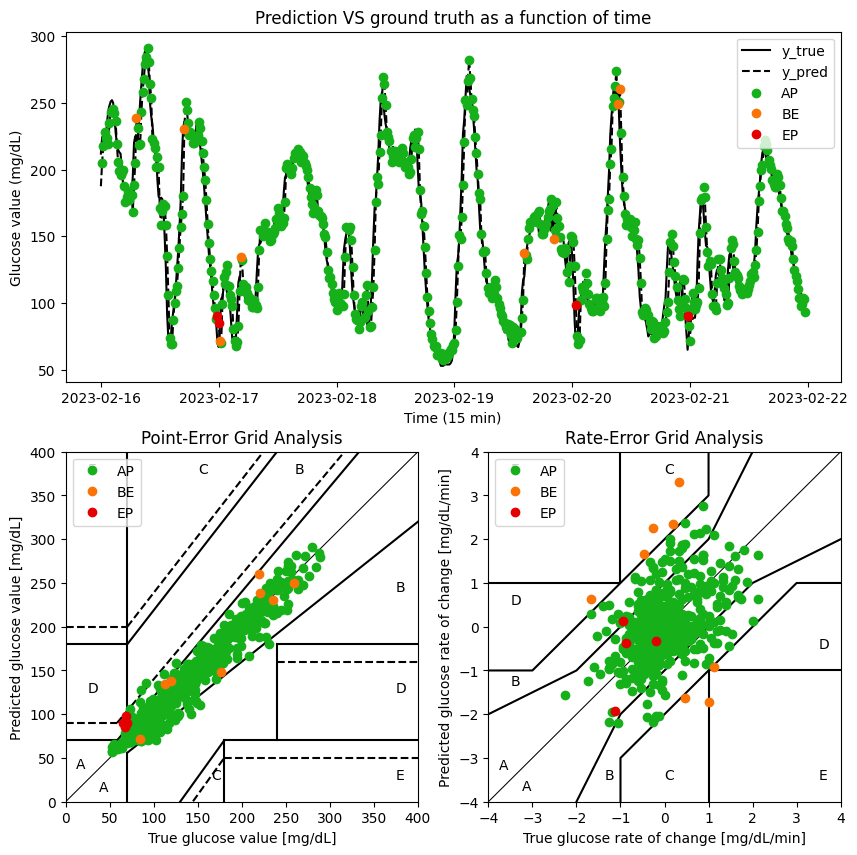

In [105]:
cg_ega = CG_EGA(dfPlot, 15)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)

In [106]:
cg_ega.per_sample()

datetime  y_true      y_pred   dy_true   dy_pred CG_EGA P_EGA  \
0    2023-02-16 00:00:00   212.0  187.546936       NaN       NaN    NaN   NaN   
1    2023-02-16 00:15:00   224.0  205.078506  0.800000  1.168771     AP     A   
2    2023-02-16 00:30:00   226.0  217.799957  0.133333  0.848097     AP     A   
3    2023-02-16 00:45:00   227.0  227.980637  0.066667  0.678712     AP     A   
4    2023-02-16 01:00:00   223.0  223.734833 -0.266667 -0.283054     AP     A   
...                  ...     ...         ...       ...       ...    ...   ...   
1737 2023-03-06 02:15:00   116.0  134.719528 -0.533333 -3.399025     BE     A   
1738 2023-03-06 02:30:00   117.0   99.232292  0.066667 -2.365816     BE     A   
1739 2023-03-06 02:45:00   114.0  100.388031 -0.200000  0.077049     AP     A   
1740 2023-03-06 03:00:00   101.0  109.266541 -0.866667  0.591901     AP     A   
1741 2023-03-06 03:15:00    89.0  108.804344 -0.800000 -0.030813     AP     B   

     R_EGA  
0      NaN  
1        A  
2        A  
3        A  
4        A  
...    ...  
1737    lC  
1738    lC  
1739     A  
1740     B  
1741     A  

[1742 rows x 8 columns]

# Predicción a 60 min del conjunto de pruebas generales

In [107]:
lenHorizonte=2
XTest=[]
YTest=[]
for i in range(lenHorizonte):
    XTest.append(array_Xtest[i]) 
    YTest.append(array_Ytest[i]) 
XTest=np.reshape(XTest, (lenHorizonte, array_Xtest.shape[1],array_Xtest.shape[2]))

df_YTest = pd.DataFrame(YTest, columns=['Glucose level True'])

YTest_scaled=scalerGlucosa.inverse_transform(YTest)
df_YTest_scaled = pd.DataFrame(YTest_scaled, columns=['Glucose level True']) 

In [108]:
yhat = model.predict(XTest)
df_glucose = pd.DataFrame(yhat, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest['Glucose level True']
df_glucose.head()

1/1 [==============================] - 0s 25ms/step


Glucose level Predict  Glucose level True
0               0.320754            0.373913
1               0.358866            0.400000

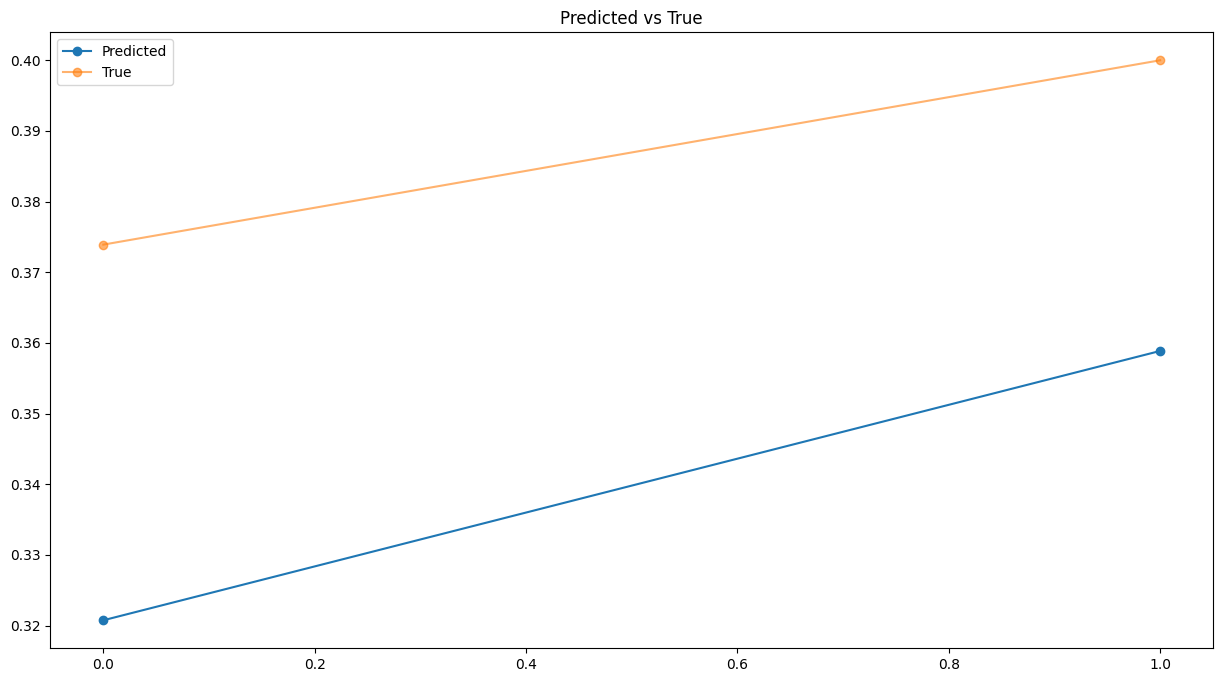

{'mae': 0.04714626954949422,
 'mse': 0.04752811562681208,
 'rmse': 0.0022589217750356187}

In [109]:
model_utils.plotPredicted(yhat,YTest)
model_utils.forecast_accuracy(yhat,YTest)

In [110]:
yhat_scaled=scalerGlucosa.inverse_transform(yhat)
df_glucose = pd.DataFrame(yhat_scaled, columns=['Glucose level Predict'])
df_glucose['Glucose level True']=df_YTest_scaled['Glucose level True']
df_glucose.head()

Glucose level Predict  Glucose level True
0             187.546936               212.0
1             205.078506               224.0

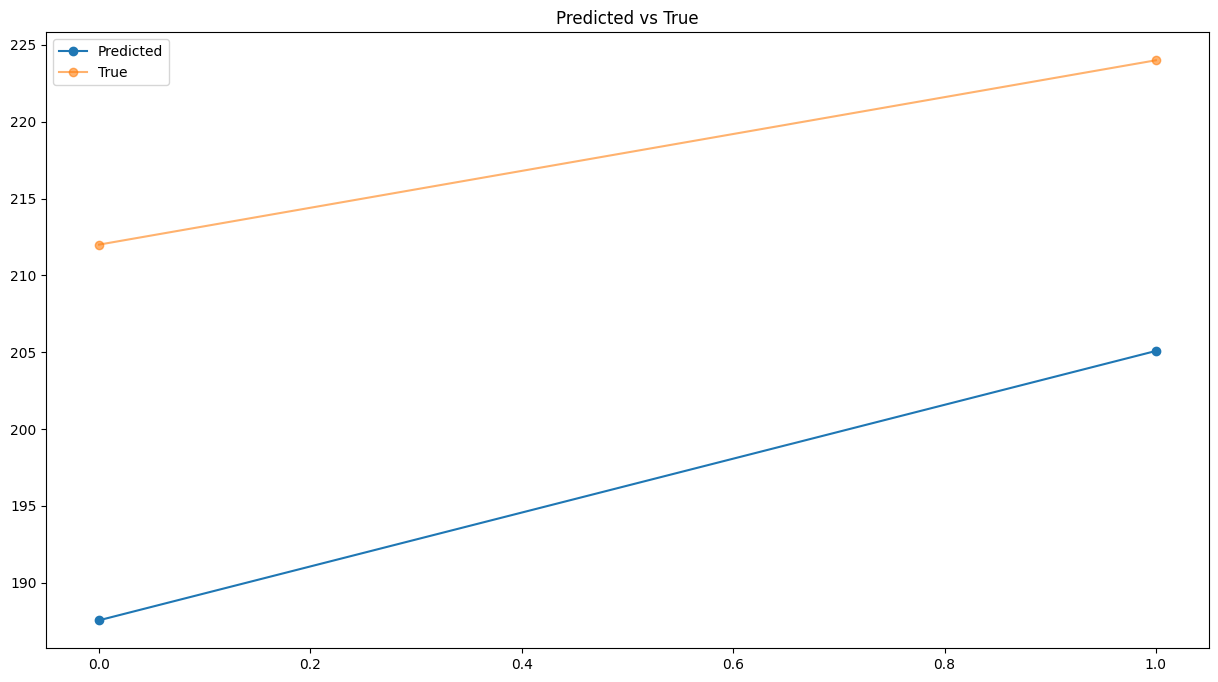

{'mae': 21.687278747558594,
 'mse': 21.862928151152573,
 'rmse': 477.98762734245975}

In [111]:
model_utils.plotPredicted(yhat_scaled,YTest_scaled)
model_utils.forecast_accuracy(yhat_scaled,YTest_scaled)